In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.svm import SVC
warnings.simplefilter('ignore')
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.metrics import r2_score

In [2]:
df_t=pd.read_csv("train.csv")
df_t['일시']= df_t['일시'].astype('str')
df_t['일시']=pd.to_datetime(df_t['일시'])
df_t['광진구']=df_t['광진구']*1000
df_t['동대문구']=df_t['동대문구']*1000
df_t['성동구']=df_t['성동구']*1000
df_t['중랑구']=df_t['중랑구']*1000

In [3]:
data = pd.read_csv("data.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data['일시']= data['일시'].astype('str')
data['일시']=pd.to_datetime(data['일시'])

In [4]:
df = pd.merge(df_t, data, how='outer',on='일시')

In [5]:
df['년']=pd.to_datetime(df['일시']).dt.year
df['월']=pd.to_datetime(df['일시']).dt.month
df['일']=pd.to_datetime(df['일시']).dt.day
df['요일'] = pd.to_datetime(df['일시']).dt.weekday
df.loc[((df['월'] <= 3)) , '계절'] = 0
df.loc[((df['월'] > 3) & (df['월'] <= 6)) , '계절'] = 1
df.loc[((df['월'] > 6) & (df['월'] <= 9)) , '계절'] = 2
df.loc[((df['월'] > 9) & (df['월'] <= 12)) , '계절'] = 3

In [6]:
import holidays
holiday_list = pd.date_range(start='2018-01-01', end='2021-12-31', freq='D')
kr_holidays = holidays.KR()
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(holiday_list)
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1.0 if x in kr_holidays else 0.0)
holiday_df.rename(columns = {'ds':'일시', 'holiday':'휴일'}, inplace = True)


In [7]:
df = pd.merge(df, holiday_df, how='outer',on='일시')
df

,일시,광진구,동대문구,성동구,중랑구,광진구오존,광진구미세먼지,동대문구오존,동대문구미세먼지,성동구오존,...,습도,여름체감,가입 수,확진자,년,월,일,요일,계절,휴일
0,2018-01-01,592.0,368.0,580.0,162.0,0.012,42.0,0.013,46.0,0.009,...,0.0,0.0,302.0,0.0,2018,1,1,0,0.0,1.0
1,2018-01-02,840.0,614.0,1034.0,260.0,0.011,43.0,0.012,43.0,0.009,...,0.0,0.0,246.0,0.0,2018,1,2,1,0.0,0.0
2,2018-01-03,828.0,576.0,952.0,288.0,0.017,34.0,0.017,37.0,0.014,...,0.0,0.0,205.0,0.0,2018,1,3,2,0.0,0.0
3,2018-01-04,792.0,542.0,914.0,292.0,0.014,44.0,0.010,48.0,0.008,...,0.0,0.0,169.0,0.0,2018,1,4,3,0.0,0.0
4,2018-01-05,818.0,602.0,994.0,308.0,0.008,64.0,0.009,65.0,0.006,...,0.0,0.0,183.0,0.0,2018,1,5,4,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2021-12-27,3830.0,3416.0,2908.0,2350.0,0.011,23.0,0.008,30.0,0.007,...,0.0,0.0,229.0,78.0,2021,12,27,0,3.0,0.0
1457,2021-12-28,4510.0,3890.0,3714.0,2700.0,0.003,42.0,0.003,51.0,0.002,...,0.0,0.0,291.0,77.0,2021,12,28,1,3.0,0.0
1458,2021-12-29,4490.0,3524.0,3660.0,2524.0,0.008,54.0,0.010,65.0,0.009,...,0.0,0.0,337.0,180.0,2021,12,29,2,3.0,0.0
1459,2021-12-30,4444.0,3574.0,3530.0,2506.0,0.022,26.0,0.027,26.0,0.025,...,0.0,0.0,283.0,113.0,2021,12,30,3,3.0,0.0


In [8]:
from sklearn.preprocessing import StandardScaler

df_num = df[['광진구오존', '광진구미세먼지', '동대문구오존',
       '동대문구미세먼지', '성동구오존', '성동구미세먼지', '중랑구오존', '중랑구미세먼지', '광진구유동인구',
       '동대문구유동인구', '성동구유동인구', '중랑구유동인구', '강수량', '겨울기온', '풍속', '겨울체감', '여름기온',
       '습도', '여름체감', '가입 수', '확진자', '요일', '년', '월', '일', '계절', '휴일']]
sc = StandardScaler()
df_num_sc = sc.fit_transform(df_num)
df_num_sc = pd.DataFrame(df_num_sc, columns=df_num.columns)
df_sc = pd.concat([df_num_sc, df[['일시', '광진구', '동대문구', '성동구', '중랑구']]], axis=1)

# 동대문구 예측

In [9]:
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib as mat
#한글폰트 나눔스퀘어 지정
mat.rcParams['font.family'] = 'NanumSquare'

In [10]:
df2=df_sc.drop(['광진구오존','광진구미세먼지','성동구오존','성동구미세먼지','동대문구오존','동대문구미세먼지',
              '광진구유동인구','성동구유동인구','동대문구유동인구','광진구','성동구','동대문구'],axis=1)

df3 = df2.set_index('일시')

split = "2021-01-01"

df_train = df3[:split]
df_test = df3[split:]

df_train_y = df_train.loc[:,'중랑구']
df_train_x = df_train.drop('중랑구', axis=1)
df_test_y = df_test.loc[:,'중랑구']
df_test_x = df_test.drop('중랑구', axis=1)

df_test_orig = df_test.loc[:, ['중랑구']]

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [12]:
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print('###',model.__class__.__name__,'###')
    evaluate_regr(y_test, pred)

In [13]:
from sklearn.linear_model import LinearRegression , Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lr_reg = LinearRegression()
ridge_reg = Ridge(random_state = 2022, alpha=10)
lasso_reg = Lasso(random_state = 2022, alpha=0.001)
rf_reg = RandomForestRegressor(random_state = 2022, n_estimators=500)
gbm_reg = GradientBoostingRegressor(random_state = 2022, n_estimators=500)
xgb_reg = XGBRegressor(random_state = 2022, n_estimators=500)
lgbm_reg = LGBMRegressor(random_state = 2022, n_estimators=500)

In [14]:
for model in [lr_reg,ridge_reg, lasso_reg, rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model,df_train_x, df_test_x, df_train_y, df_test_y,is_expm1=True)

### LinearRegression ###
RMSLE: 0.328, RMSE: 1161.315, MAE: 982.016
### Ridge ###
RMSLE: 0.339, RMSE: 1260.986, MAE: 1070.108
### Lasso ###
RMSLE: 0.329, RMSE: 1167.459, MAE: 987.933
### RandomForestRegressor ###
RMSLE: 0.776, RMSE: 2355.610, MAE: 2032.619
### GradientBoostingRegressor ###
RMSLE: 0.520, RMSE: 2080.744, MAE: 1812.612
### XGBRegressor ###
RMSLE: 0.640, RMSE: 2250.303, MAE: 1962.938
### LGBMRegressor ###
RMSLE: 0.635, RMSE: 2285.135, MAE: 1997.552


# 예측 결과

<AxesSubplot:xlabel='일시'>

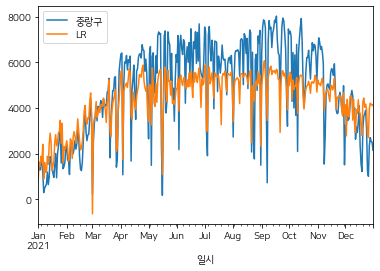

In [15]:
lr_reg = LinearRegression()
lr_reg.fit(df_train_x, df_train_y)
pred = lr_reg.predict(df_test_x)

result = pd.concat([df_test_orig.reset_index(), pd.DataFrame(pred, columns=['LR'])], axis=1, ignore_index=False)
result = result.set_index('일시')
result = result.loc[:, ['중랑구', 'LR']]
result.plot()